In [1]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def load_database_sizes(schema_file):
    # 加载 schema 文件内容
    with open(schema_file, 'r', encoding='utf-8') as f:
        schema_data = json.load(f)

    database_sizes = {}
    for db in schema_data:
        db_name = db["database"]
        size = db["table_count"] + db["total_column_count"]
        database_sizes[db_name] = size
    return database_sizes

In [3]:
def calculate_precision_by_database(golden_file, dev_file):
    # 加载文件内容
    with open(golden_file, 'r', encoding='utf-8') as f:
        golden_data = json.load(f)
    with open(dev_file, 'r', encoding='utf-8') as f:
        dev_data = json.load(f)

    database_precisions = defaultdict(list)  # 存储每个 database 的精确度列表

    # 遍历每个问题
    for golden, dev in zip(golden_data, dev_data):
        correct_links = 0  # 预测正确的表/列数
        total_predictions = 0  # 预测的表/列总数

        is_count_star = "count(*)" in golden["gold_sql"].lower()
        golden_links = set()
        for table in golden["tables"]:
            table_name = table["table"].lower()
            if not is_count_star or table["columns"]:  # 仅当没有 COUNT(*) 或列非空时才记录
                golden_links.update((table_name, col.lower()) for col in table["columns"])

        # 获取 Dev 的表和列
        dev_links = set(
            (table["table"].lower(), col.lower()) 
            for table in dev["tables"] 
            for col in table["columns"]
        )

        # 如果是 COUNT(*)，所有 dev_links 都视为正确
        if is_count_star:
            correct_links += len(dev_links)
        else:
            # 统计正确预测和总预测
            correct_links += len(golden_links & dev_links)  # 交集的数量
        total_predictions += len(dev_links)  # Dev 预测的数量

        # 计算精确度
        precision = correct_links / total_predictions if total_predictions > 0 else 0

        # 根据 database 存储精确度
        database_name = golden["database"]
        database_precisions[database_name].append(precision)

    # 聚合计算每个 database 的平均精确度
    database_avg_precision = {
        db: sum(precisions) / len(precisions) for db, precisions in database_precisions.items()
    }
    return database_avg_precision



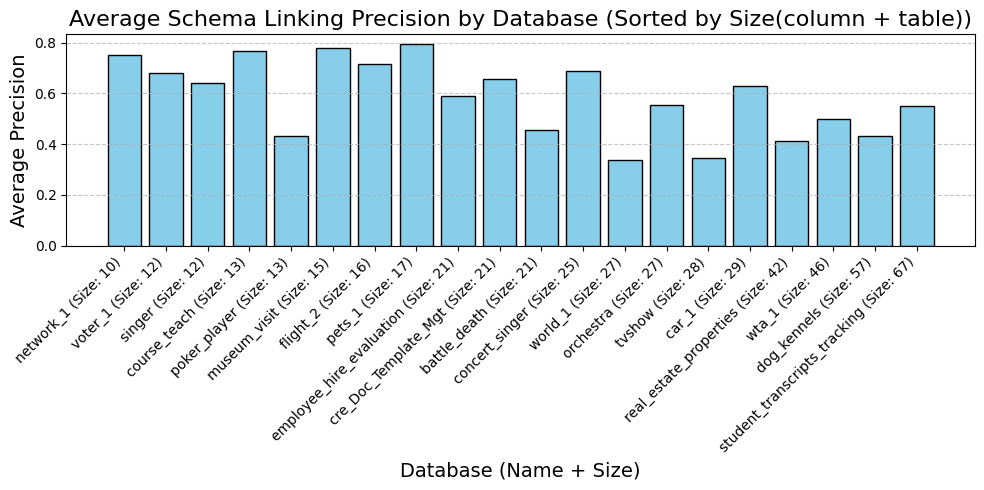

In [4]:
# 文件路径: spider dev gnn100
golden_file = "../data/gold_schema_linking/spider_dev_gold_schema_linking.json"
dev_file = "../linked_schema_spider_dev_gnn100.json"
schema_file = "../data/db_schema/spider_schemas.json"

# 计算每个 database 的平均精确度
database_avg_precision = calculate_precision_by_database(golden_file, dev_file)

# 加载每个数据库的大小
database_sizes = load_database_sizes(schema_file)

# 根据大小排序数据库
sorted_databases = sorted(database_avg_precision.keys(), key=lambda db: database_sizes.get(db, 0))

# 排序后的精确度和横坐标标签
sorted_avg_precisions = [database_avg_precision[db] for db in sorted_databases]
sorted_sizes = [database_sizes[db] for db in sorted_databases]
sorted_labels = [f"{db} (Size: {size})" for db, size in zip(sorted_databases, sorted_sizes)]  # 拼接标签

# 作图
plt.figure(figsize=(10, 5))
plt.bar(sorted_labels, sorted_avg_precisions, color='skyblue', edgecolor='black')
plt.title("Average Schema Linking Precision by Database (Sorted by Size(column + table))", fontsize=16)
plt.xlabel("Database (Name + Size)", fontsize=14)
plt.ylabel("Average Precision", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

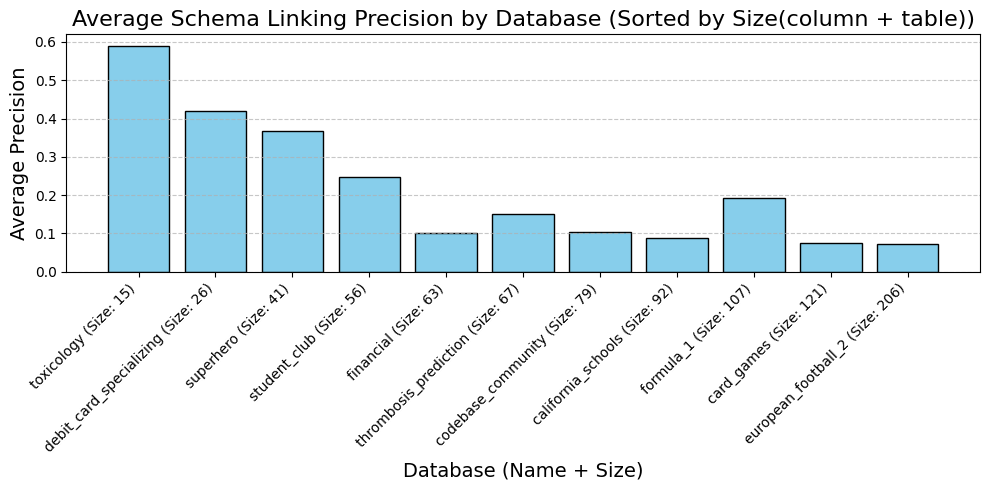

In [5]:
# 文件路径: spider dev gnn100
golden_file = "../data/gold_schema_linking/bird_dev_gold_schema_linking.json"
dev_file = "../linked_schema_bird_dev_gnn100.json"
schema_file = "../data/db_schema/bird_dev_schemas.json"

# 计算每个 database 的平均精确度
database_avg_precision = calculate_precision_by_database(golden_file, dev_file)

# 加载每个数据库的大小
database_sizes = load_database_sizes(schema_file)

# 根据大小排序数据库
sorted_databases = sorted(database_avg_precision.keys(), key=lambda db: database_sizes.get(db, 0))

# 排序后的精确度和横坐标标签
sorted_avg_precisions = [database_avg_precision[db] for db in sorted_databases]
sorted_sizes = [database_sizes[db] for db in sorted_databases]
sorted_labels = [f"{db} (Size: {size})" for db, size in zip(sorted_databases, sorted_sizes)]  # 拼接标签

# 作图
plt.figure(figsize=(10, 5))
plt.bar(sorted_labels, sorted_avg_precisions, color='skyblue', edgecolor='black')
plt.title("Average Schema Linking Precision by Database (Sorted by Size(column + table))", fontsize=16)
plt.xlabel("Database (Name + Size)", fontsize=14)
plt.ylabel("Average Precision", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
# recall

def calculate_recall_by_database(golden_file, dev_file):
    # 加载文件内容
    with open(golden_file, 'r', encoding='utf-8') as f:
        golden_data = json.load(f)
    with open(dev_file, 'r', encoding='utf-8') as f:
        dev_data = json.load(f)

    database_recalls = defaultdict(list)  # 存储每个 database 的精确度列表

    # 遍历每个问题
    for golden, dev in zip(golden_data, dev_data):
        correct_links = 0  # 预测正确的表/列数
        total_actual_links = 0  # 实际的表/列总数

        is_count_star = "count(*)" in golden["gold_sql"].lower()
        golden_links = set()
        for table in golden["tables"]:
            table_name = table["table"].lower()
            if not is_count_star or table["columns"]:  # 仅当没有 COUNT(*) 或列非空时才记录
                golden_links.update((table_name, col.lower()) for col in table["columns"])

        # 获取 Dev 的表和列
        dev_links = set(
            (table["table"].lower(), col.lower()) 
            for table in dev["tables"] 
            for col in table["columns"]
        )

        # 如果是 COUNT(*)，所有 golden_links  都视为正确
        if is_count_star:
            correct_links += len(golden_links)
        else:
            # 统计正确预测和总预测
            correct_links += len(golden_links & dev_links)  # 交集的数量
        total_actual_links += len(golden_links)  # 实际的表/列总数

        # 计算召回率
        recall = correct_links / total_actual_links if total_actual_links > 0 else 0

        # 根据 database 存储召回率
        database_name = golden["database"]
        database_recalls[database_name].append(recall)

    # 聚合计算每个 database 的平均召回率
    database_avg_recall = {
        db: sum(recalls) / len(recalls) for db, recalls in database_recalls.items()
    }
    return database_avg_recall

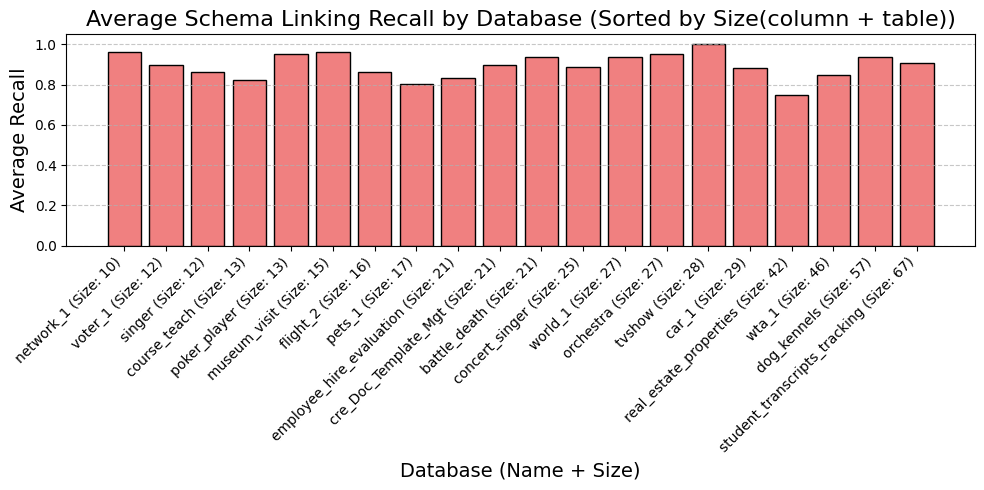

In [8]:
# 文件路径: spider dev gnn100
golden_file = "../data/gold_schema_linking/spider_dev_gold_schema_linking.json"
dev_file = "../linked_schema_spider_dev_gnn100.json"
schema_file = "../data/db_schema/spider_schemas.json"

# 计算每个 database 的平均召回率
database_avg_recall = calculate_recall_by_database(golden_file, dev_file)

# 加载每个数据库的大小
database_sizes = load_database_sizes(schema_file)

# 根据大小排序数据库
sorted_databases = sorted(database_avg_recall.keys(), key=lambda db: database_sizes.get(db, 0))

# 排序后的召回率和横坐标标签
sorted_avg_recalls = [database_avg_recall[db] for db in sorted_databases]
sorted_sizes = [database_sizes[db] for db in sorted_databases]
sorted_labels = [f"{db} (Size: {size})" for db, size in zip(sorted_databases, sorted_sizes)]  # 拼接标签

# 作图
plt.figure(figsize=(10, 5))
plt.bar(sorted_labels, sorted_avg_recalls, color='lightcoral', edgecolor='black')
plt.title("Average Schema Linking Recall by Database (Sorted by Size(column + table))", fontsize=16)
plt.xlabel("Database (Name + Size)", fontsize=14)
plt.ylabel("Average Recall", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

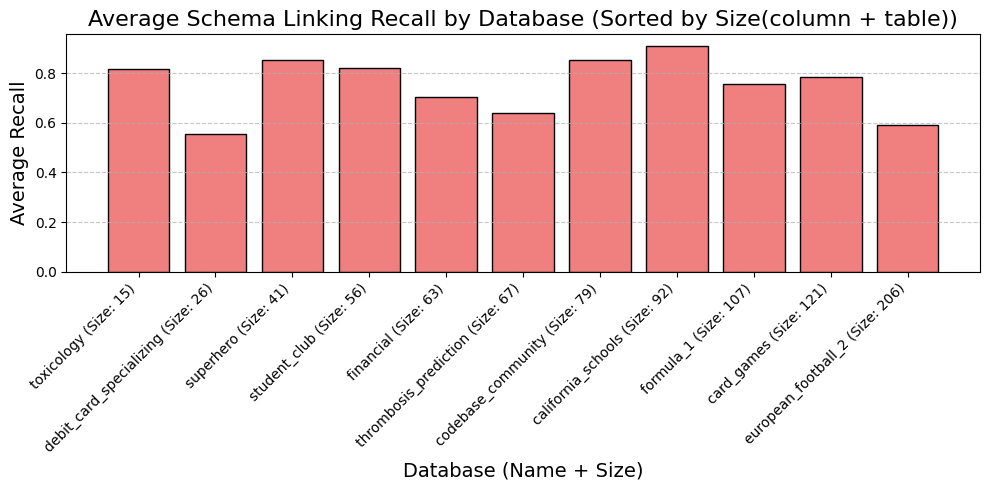

In [9]:
# 文件路径: spider dev gnn100
golden_file = "../data/gold_schema_linking/bird_dev_gold_schema_linking.json"
dev_file = "../linked_schema_bird_dev_gnn100.json"
schema_file = "../data/db_schema/bird_dev_schemas.json"

# 计算每个 database 的平均召回率
database_avg_recall = calculate_recall_by_database(golden_file, dev_file)

# 加载每个数据库的大小
database_sizes = load_database_sizes(schema_file)

# 根据大小排序数据库
sorted_databases = sorted(database_avg_recall.keys(), key=lambda db: database_sizes.get(db, 0))

# 排序后的召回率和横坐标标签
sorted_avg_recalls = [database_avg_recall[db] for db in sorted_databases]
sorted_sizes = [database_sizes[db] for db in sorted_databases]
sorted_labels = [f"{db} (Size: {size})" for db, size in zip(sorted_databases, sorted_sizes)]  # 拼接标签

# 作图
plt.figure(figsize=(10, 5))
plt.bar(sorted_labels, sorted_avg_recalls, color='lightcoral', edgecolor='black')
plt.title("Average Schema Linking Recall by Database (Sorted by Size(column + table))", fontsize=16)
plt.xlabel("Database (Name + Size)", fontsize=14)
plt.ylabel("Average Recall", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

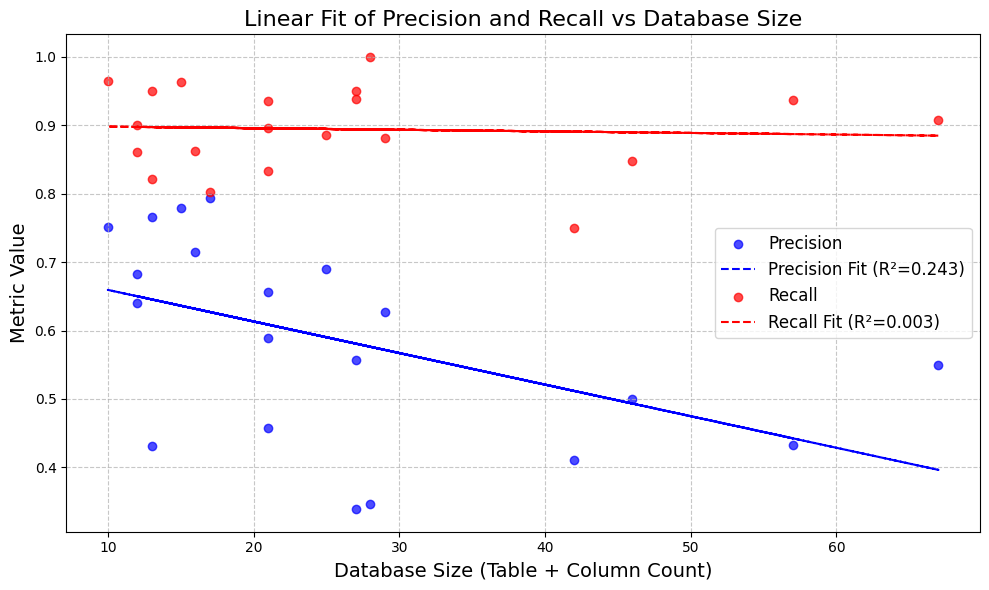

Precision Fit: Slope=-0.0046, Intercept=0.7057, R²=0.2434
Recall Fit: Slope=-0.0002, Intercept=0.9005, R²=0.0034


In [10]:
#这个是线性拟合precision/recall 和 database size 

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 计算线性拟合的辅助函数
def plot_linear_fit(x, y, label, color, linestyle):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    fitted_y = slope * np.array(x) + intercept
    plt.plot(x, fitted_y, color=color, linestyle=linestyle, label=f"{label} Fit (R²={r_value**2:.3f})")
    return slope, intercept, r_value**2

# 文件路径
golden_file = "../data/gold_schema_linking/spider_dev_gold_schema_linking.json"
dev_file = "../linked_schema_spider_dev_gnn100.json"
schema_file = "../data/db_schema/spider_schemas.json"

# 计算平均 Precision 和 Recall
database_avg_precision = calculate_precision_by_database(golden_file, dev_file)
database_avg_recall = calculate_recall_by_database(golden_file, dev_file)

# 加载数据库大小
database_sizes = load_database_sizes(schema_file)

# 整理数据
databases = list(database_avg_precision.keys())
sizes = [database_sizes[db] for db in databases]
precisions = [database_avg_precision[db] for db in databases]
recalls = [database_avg_recall[db] for db in databases]

# 作图
plt.figure(figsize=(10, 6))

# Precision vs Size
plt.scatter(sizes, precisions, color="blue", label="Precision", alpha=0.7)
slope_p, intercept_p, r2_p = plot_linear_fit(sizes, precisions, "Precision", color="blue", linestyle="--")

# Recall vs Size
plt.scatter(sizes, recalls, color="red", label="Recall", alpha=0.7)
slope_r, intercept_r, r2_r = plot_linear_fit(sizes, recalls, "Recall", color="red", linestyle="--")

# 图例和标题
plt.title("Linear Fit of Precision and Recall vs Database Size", fontsize=16)
plt.xlabel("Database Size (Table + Column Count)", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 输出拟合结果
print(f"Precision Fit: Slope={slope_p:.4f}, Intercept={intercept_p:.4f}, R²={r2_p:.4f}")
print(f"Recall Fit: Slope={slope_r:.4f}, Intercept={intercept_r:.4f}, R²={r2_r:.4f}")

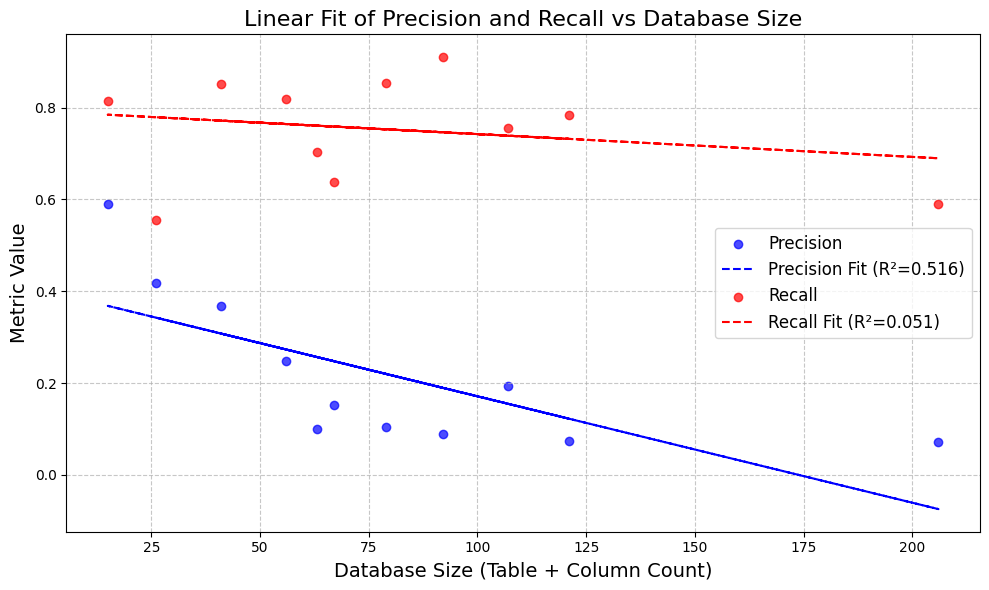

Precision Fit: Slope=-0.0023, Intercept=0.4031, R²=0.5160
Recall Fit: Slope=-0.0005, Intercept=0.7921, R²=0.0513


In [11]:
#这个是线性拟合precision/recall 和 database size 

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 计算线性拟合的辅助函数
def plot_linear_fit(x, y, label, color, linestyle):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    fitted_y = slope * np.array(x) + intercept
    plt.plot(x, fitted_y, color=color, linestyle=linestyle, label=f"{label} Fit (R²={r_value**2:.3f})")
    return slope, intercept, r_value**2

# 文件路径
golden_file = "../data/gold_schema_linking/bird_dev_gold_schema_linking.json"
dev_file = "../linked_schema_bird_dev_gnn100.json"
schema_file = "../data/db_schema/bird_dev_schemas.json"

# 计算平均 Precision 和 Recall
database_avg_precision = calculate_precision_by_database(golden_file, dev_file)
database_avg_recall = calculate_recall_by_database(golden_file, dev_file)

# 加载数据库大小
database_sizes = load_database_sizes(schema_file)

# 整理数据
databases = list(database_avg_precision.keys())
sizes = [database_sizes[db] for db in databases]
precisions = [database_avg_precision[db] for db in databases]
recalls = [database_avg_recall[db] for db in databases]

# 作图
plt.figure(figsize=(10, 6))

# Precision vs Size
plt.scatter(sizes, precisions, color="blue", label="Precision", alpha=0.7)
slope_p, intercept_p, r2_p = plot_linear_fit(sizes, precisions, "Precision", color="blue", linestyle="--")

# Recall vs Size
plt.scatter(sizes, recalls, color="red", label="Recall", alpha=0.7)
slope_r, intercept_r, r2_r = plot_linear_fit(sizes, recalls, "Recall", color="red", linestyle="--")

# 图例和标题
plt.title("Linear Fit of Precision and Recall vs Database Size", fontsize=16)
plt.xlabel("Database Size (Table + Column Count)", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 输出拟合结果
print(f"Precision Fit: Slope={slope_p:.4f}, Intercept={intercept_p:.4f}, R²={r2_p:.4f}")
print(f"Recall Fit: Slope={slope_r:.4f}, Intercept={intercept_r:.4f}, R²={r2_r:.4f}")